In [771]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk, string
import spacy
import re
from transformers import pipeline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from matplotlib import pyplot
from math import log1p
from sklearn import preprocessing

nltk.download('vader_lexicon')

nlp = spacy.load("en_core_web_lg")

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lizhenni/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [292]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/lizhenni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [293]:
df = pd.read_csv('../data/philosophy_data.csv')

In [294]:
df

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350,1997,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350,1997,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."
...,...,...,...,...,...,...,...,...,...,...,...
360803,"Women, Race, And Class",Davis,feminism,But the socialization of housework including m...,But the socialization of housework including m...,1981,1981,142,but the socialization of housework including m...,"['but', 'the', 'socialization', 'of', 'housewo...",but the socialization of housework include me...
360804,"Women, Race, And Class",Davis,feminism,The only significant steps toward endingdomest...,The only significant steps toward endingdomest...,1981,1981,117,the only significant steps toward endingdomest...,"['the', 'only', 'significant', 'steps', 'towar...",the only significant step toward endingdomest...
360805,"Women, Race, And Class",Davis,feminism,"Working women, therefore, have a special and v...","Working women, therefore, have a special and v...",1981,1981,90,"working women, therefore, have a special and v...","['working', 'women', 'therefore', 'have', 'spe...","working woman , therefore , have a special an..."
360806,"Women, Race, And Class",Davis,feminism,"Moreover, under capitalism, campaigns for jobs...","Moreover, under capitalism, campaigns for jobs...",1981,1981,199,"moreover, under capitalism, campaigns for jobs...","['moreover', 'under', 'capitalism', 'campaigns...","moreover , under capitalism , campaign for jo..."


In [425]:
author2school = dict(zip(df.author, df.school))
title2author = dict(zip(df.title, df.author))

## overview

In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360808 entries, 0 to 360807
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   title                      360808 non-null  object
 1   author                     360808 non-null  object
 2   school                     360808 non-null  object
 3   sentence_spacy             360808 non-null  object
 4   sentence_str               360808 non-null  object
 5   original_publication_date  360808 non-null  int64 
 6   corpus_edition_date        360808 non-null  int64 
 7   sentence_length            360808 non-null  int64 
 8   sentence_lowered           360808 non-null  object
 9   tokenized_txt              360808 non-null  object
 10  lemmatized_str             360808 non-null  object
dtypes: int64(3), object(8)
memory usage: 30.3+ MB


There are 360,808 entries. Each of the entry's a sentence from a philosophical text. There are 51 philosophical texts spanning 10 core schools.
The schools such as 'plato' and 'aristotle' have only their own books; others such as 'empiricism' are represented by several authors.

In [297]:
titles = df.title.unique()

In [298]:
len(titles)

59

There are 59 articles.

### reference

In [299]:
philosophers = df.author.unique()
philosophers

array(['Plato', 'Aristotle', 'Locke', 'Hume', 'Berkeley', 'Spinoza',
       'Leibniz', 'Descartes', 'Malebranche', 'Russell', 'Moore',
       'Wittgenstein', 'Lewis', 'Quine', 'Popper', 'Kripke', 'Foucault',
       'Derrida', 'Deleuze', 'Merleau-Ponty', 'Husserl', 'Heidegger',
       'Kant', 'Fichte', 'Hegel', 'Marx', 'Lenin', 'Smith', 'Ricardo',
       'Keynes', 'Epictetus', 'Marcus Aurelius', 'Nietzsche',
       'Wollstonecraft', 'Beauvoir', 'Davis'], dtype=object)

In [300]:
len(philosophers)

36

There are 36 philosophers in the data set.   
Are there any reference?

Reference: name / school / title

In [301]:
references = pd.DataFrame()
references['philosophers'] = philosophers

for title in titles:
    reference = []
    temp_df = df[df.title == title]
    for philosopher in philosophers:
        temp = 0
        for sentence in temp_df.tokenized_txt:
            temp += sentence.count(philosopher.lower())
        reference.append(temp)
    references[title] = reference

In [302]:
references

,philosophers,Plato - Complete Works,Aristotle - Complete Works,Second Treatise On Government,Essay Concerning Human Understanding,A Treatise Of Human Nature,Dialogues Concerning Natural Religion,Three Dialogues,A Treatise Concerning The Principles Of Human Knowledge,Ethics,...,Enchiridion,Meditations,The Antichrist,Beyond Good And Evil,Ecce Homo,Twilight Of The Idols,Thus Spake Zarathustra,Vindication Of The Rights Of Woman,The Second Sex,"Women, Race, And Class"
0,Plato,31,76,0,7,2,1,0,0,0,...,0,7,2,23,4,26,0,2,29,0
1,Aristotle,0,0,0,2,0,0,0,2,0,...,0,0,1,0,2,4,0,0,10,0
2,Locke,8,8,0,2,3,0,0,1,0,...,0,0,0,4,0,0,3,2,19,3
3,Hume,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,Berkeley,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,Spinoza,0,0,0,0,6,0,1,0,1,...,0,0,1,5,0,4,0,0,1,0
6,Leibniz,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,2,0,0,1,0
7,Descartes,0,0,0,4,0,0,0,0,2,...,0,0,2,3,1,2,0,0,1,0
8,Malebranche,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Russell,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [303]:
references.sum(axis=0)

philosophers                                               PlatoAristotleLockeHumeBerkeleySpinozaLeibnizD...
Plato - Complete Works                                                                                    51
Aristotle - Complete Works                                                                                96
Second Treatise On Government                                                                              0
Essay Concerning Human Understanding                                                                      18
A Treatise Of Human Nature                                                                                14
Dialogues Concerning Natural Religion                                                                      2
Three Dialogues                                                                                            2
A Treatise Concerning The Principles Of Human Knowledge                                                    3
Ethics             

In [304]:
references.sum(axis=1, numeric_only=True)

0     639
1     502
2     278
3     389
4     111
5     151
6     214
7     697
8      49
9     698
10     92
11     78
12    163
13    239
14      5
15     40
16    132
17     85
18      7
19      0
20    278
21    146
22    828
23     61
24    512
25    523
26     16
27    422
28    117
29     38
30      7
31      0
32    368
33      3
34      6
35      3
dtype: int64

In [305]:
df2 = df[['author', 'school']].drop_duplicates()

In [306]:
df2['references'] = list(references.sum(axis=1, numeric_only=True))
df2

,author,school,references
0,Plato,plato,639
38366,Aristotle,aristotle,502
87145,Locke,empiricism,278
96030,Hume,empiricism,389
104342,Berkeley,empiricism,111
107076,Spinoza,rationalism,151
110869,Leibniz,rationalism,214
115896,Descartes,rationalism,697
117028,Malebranche,rationalism,49
130025,Russell,analytic,698


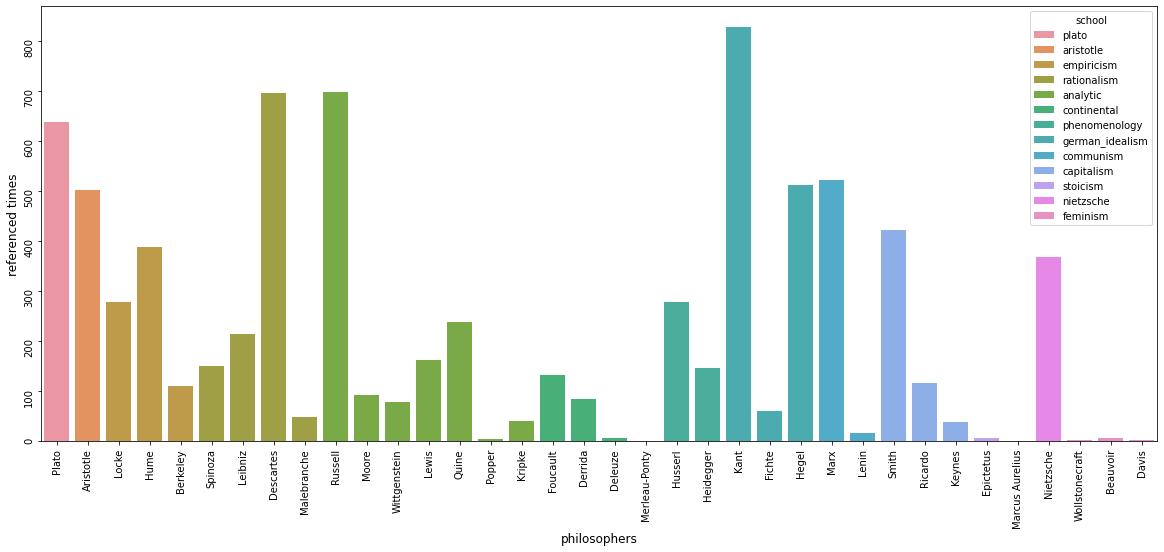

In [155]:
fig,ax = plt.subplots(1,1,figsize=(20,8));

sns.barplot(x='author', y='references', data=df2, hue='school', dodge=False);
ax.set_xlabel('philosophers', fontsize=12);
ax.set_ylabel('referenced times', fontsize=12);
ax.tick_params(rotation=90);

The philosophers often being referenced are: Kant, Russell, Descartes, Plato.

In [420]:
df3 = df[['title', 'author', 'school']].drop_duplicates()
most_mentioned = []
mention_time = []

for title in titles:
    m_time = references[title].max()
    mention_time.append(m_time)
    most_mentioned.append(references[references[title] == m_time].philosophers.iloc[0])

In [435]:
df3['most mentioned'] = most_mentioned
df3['mention time'] = mention_time

In [439]:
df3['mentioned school'] = [author2school[x] for x in df3['most mentioned']]

/var/folders/pn/8ps1h0fs0cx57rhg5p2mv1tr0000gn/T/ipykernel_94280/3177477802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['mentioned school'] = [author2school[x] for x in df3['most mentioned']]


In [438]:
df3 = df3[(df3.author != df3['most mentioned']) & (df3['mention time'] != 0)]
df3

,title,author,school,most mentioned,mention time,mentioned school
38366,Aristotle - Complete Works,Aristotle,aristotle,Plato,76,plato
88288,Essay Concerning Human Understanding,Locke,empiricism,Plato,7,plato
96030,A Treatise Of Human Nature,Hume,empiricism,Spinoza,6,rationalism
103077,Dialogues Concerning Natural Religion,Hume,empiricism,Plato,1,plato
104342,Three Dialogues,Berkeley,empiricism,Spinoza,1,rationalism
106036,A Treatise Concerning The Principles Of Human ...,Berkeley,empiricism,Aristotle,2,aristotle
107076,Ethics,Spinoza,rationalism,Descartes,2,rationalism
110869,Theodicy,Leibniz,rationalism,Aristotle,39,aristotle
115896,Discourse On Method,Descartes,rationalism,Aristotle,1,aristotle
117028,The Search After Truth,Malebranche,rationalism,Aristotle,139,aristotle


In Kripke's 'Philosophical Troubles', he mentioned Russell 485 times, who's from the same school with himself, analytics.

### Philosophical Troubles - Kripke & Russell

### sentimental

In [486]:
temp_df = df[df.title == 'Philosophical Troubles']
temp_df = temp_df[[x.find('russell') != -1 for x in temp_df.sentence_lowered]]
mentioned_sentence = list(temp_df.sentence_lowered)
mentioned_sentence[:5]

['it was i think settled quite well by bertrand russell in his notion of the scope of a description.',
 'according to russell, one can, for example, say with propriety that the author of hamlet might not have written hamlet, or even that the author of hamlet might not have been the author of hamlet.',
 "russell brings this out by saying that in such a statement, the first occurrence of the description 'the author of hamlet' has large scope.",
 "now, aside from the details of russell's particular formulation of it, which depends on his theory of descriptions, this seems to be the distinction that any theory of descriptions has to make.",
 "what he means instead, as russell points out, is 'someone is president of harvard"]

In [472]:
pos = [m.start() for m in re.finditer('russell', t1)]

In [505]:
# sentiment_pipeline = pipeline("sentiment-analysis")
# specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

In [506]:
# set up empty dataframe for staging output
df1=pd.DataFrame()
df1['row_id']=['99999999999']
df1['sentiment_type']='NA999NA'
df1['sentiment_score']=0

In [542]:
df_t = df[df.title == 'Philosophical Troubles']
df_t = df_t.reset_index()
df_t['row_id'] = df_t.index + 1
df_t = df_t[['row_id', 'sentence_lowered']]
df_t

,row_id,sentence_lowered
0,1,a problem which has arisen frequently in conte...
1,2,this question is phrased by analogy with the w...
2,3,"in both cases, it has usually been taken for g..."
3,4,i do not intend to deal with the kantian quest...
4,5,i will not discuss who was right on the possib...
...,...,...
9793,9794,i discussed the case of too in part just now.
9794,9795,the rules need not be the same for all the pre...
9795,9796,normally the presuppositions are the ones pred...
9796,9797,there may well be cases that appear to be coun...


In [538]:
df_subset = df_t[['sentence_lowered']]
df_subset = df_subset.reset_index()
df_subset['row_id'] = df_subset.index + 1
df_subset = df_subset[['row_id', 'sentence_lowered']]
df_subset

,row_id,sentence_lowered
0,1,a problem which has arisen frequently in conte...
1,2,this question is phrased by analogy with the w...
2,3,"in both cases, it has usually been taken for g..."
3,4,i do not intend to deal with the kantian quest...
4,5,i will not discuss who was right on the possib...
...,...,...
9793,9794,i discussed the case of too in part just now.
9794,9795,the rules need not be the same for all the pre...
9795,9796,normally the presuppositions are the ones pred...
9796,9797,there may well be cases that appear to be coun...


In [539]:
print('Processing sentiment analysis...')
sid = SentimentIntensityAnalyzer()
t_df = df1
for index, row in df_subset.iterrows():
    scores = sid.polarity_scores(row[1])
    for key, value in scores.items():
        temp = [key,value,row[0]]
        df1['row_id']=row[0]
        df1['sentiment_type']=key
        df1['sentiment_score']=value
        t_df=t_df.append(df1)
        
#remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.row_id != '99999999999']

#remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()

# only keep rows where sentiment_type = compound
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
t_df_cleaned

Processing sentiment analysis...


,row_id,sentiment_type,sentiment_score
0,1,compound,-0.4019
0,2,compound,0.0000
0,3,compound,0.2500
0,4,compound,-0.4939
0,5,compound,0.0000
...,...,...,...
0,9794,compound,0.0000
0,9795,compound,0.0000
0,9796,compound,0.0000
0,9797,compound,-0.4678


In [543]:
df_output = pd.merge(df_t, t_df_cleaned, on='row_id', how='inner')
df_output

,row_id,sentence_lowered,sentiment_type,sentiment_score
0,1,a problem which has arisen frequently in conte...,compound,-0.4019
1,2,this question is phrased by analogy with the w...,compound,0.0000
2,3,"in both cases, it has usually been taken for g...",compound,0.2500
3,4,i do not intend to deal with the kantian quest...,compound,-0.4939
4,5,i will not discuss who was right on the possib...,compound,0.0000
...,...,...,...,...
9793,9794,i discussed the case of too in part just now.,compound,0.0000
9794,9795,the rules need not be the same for all the pre...,compound,0.0000
9795,9796,normally the presuppositions are the ones pred...,compound,0.0000
9796,9797,there may well be cases that appear to be coun...,compound,-0.4678


Polarity score in the range of -1 to -0.5 typically indicates negative sentiment;
Polarity score greater than -0.5 and less than +0.5 typically indicates neutral sentiment;
Polarity score in the range of +0.5 to 1 typically indicates positive sentiment.

In [545]:
df_output.sentiment_score.describe()

count    9798.000000
mean        0.035593
std         0.337712
min        -0.933100
25%         0.000000
50%         0.000000
75%         0.258400
max         0.966100
Name: sentiment_score, dtype: float64

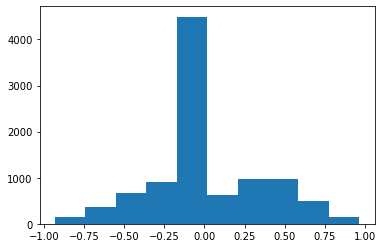

In [550]:
plt.hist(df_output.sentiment_score);

The min value is -0.933100, which indicates the polarity or intensity of the most negative response is strongly negative (range of sentiment polarity score is -1 to +1).    
The max value is +0.966100, which indicates the polarity or intensity of the most positive response is highly positive.     
The mean value is +0.035593 which indicates the average polarity or intensity of sentiment across all responses is almost neutral.

In [546]:
df_russell = df_output[[x.find('russell') != -1 for x in df_output.sentence_lowered]]
df_russell

,row_id,sentence_lowered,sentiment_type,sentiment_score
57,58,it was i think settled quite well by bertrand ...,compound,0.3384
58,59,"according to russell, one can, for example, sa...",compound,0.0000
62,63,russell brings this out by saying that in such...,compound,0.0000
66,67,"now, aside from the details of russell's parti...",compound,0.0000
72,73,"what he means instead, as russell points out, ...",compound,0.0000
...,...,...,...,...
9602,9603,"if bertrand russell is giving the lecture, it ...",compound,0.5859
9607,9608,similarly: russell's father was viscount amber...,compound,0.0000
9608,9609,russell eventually inherited the title himself...,compound,0.0000
9609,9610,one might imagine uttered at a time when russe...,compound,0.0000


In [547]:
df_russell.sentiment_score.describe()

count    441.000000
mean       0.063173
std        0.364153
min       -0.851900
25%       -0.019100
50%        0.000000
75%        0.338400
max        0.940300
Name: sentiment_score, dtype: float64

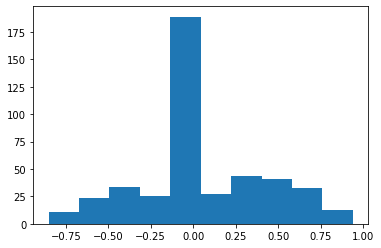

In [552]:
plt.hist(df_russell.sentiment_score);

Similarly, the sentiment of sentences mentioned Russell is averagely and mostly neutral, and other negative or positive attitudes are evenly distributed.

In [558]:
df_russell[df_russell.sentiment_score < -0.8].sentence_lowered.iloc[0]

"the premise of the argument we are considering for the classic position of frege and russell that whenever two codesignative names fail to be interchangeable in the expression of a speaker's beliefs, failure of interchangeability arises from a difference in the 'defining' descriptions the speaker associates with these names is, therefore, false."

In [560]:
df_russell[df_russell.sentiment_score > 0.9].sentence_lowered.iloc[1]

"for example taking for the moment 'cicero' and 'tully' as 'logically proper names,' russell would hold that if i judge that cicero admired tully, i am related to cicero, tully, and the admiration relation in a certain way: since cicero is tully, i am related in exactly the same way to tully, cicero, and admiration; therefore i judge that tully admired cicero."

The result makes sense as most citations are just proof of arguements, not a personal attitude towards Russell.

### similarity with Russell's

In [487]:
t1 = texts[texts.title == 'Philosophical Troubles'].text.iloc[0]

In [463]:
df[df.author == 'Russell'].title.drop_duplicates()

130025          The Analysis Of Mind
133538    The Problems Of Philosophy
Name: title, dtype: object

In [459]:
arr2[23]

array([0.50687285, 0.49559509, 0.3272194 , 0.39290304, 0.4186005 ,
       0.42643342, 0.37919305, 0.39349973, 0.31022609, 0.38913339,
       0.43733545, 0.45650125, 0.44227845, 0.44591771, 0.52037657,
       0.53044457, 0.56595099, 0.56952496, 0.39235189, 0.59380533,
       0.51881347, 0.4600184 , 0.69768877, 1.        , 0.54259449,
       0.30813309, 0.31480799, 0.43986952, 0.45889991, 0.41856874,
       0.31494972, 0.46569571, 0.4396461 , 0.39383217, 0.29185175,
       0.45028023, 0.3801236 , 0.34775011, 0.417998  , 0.4869009 ,
       0.37682751, 0.40750503, 0.46109899, 0.24761189, 0.17957996,
       0.30404042, 0.28610371, 0.16563076, 0.27119725, 0.32926727,
       0.22811727, 0.38223262, 0.44614137, 0.43734936, 0.46559624,
       0.20764487, 0.33507366, 0.35816987, 0.16503267])

In [460]:
# & The Analysis Of Mind
arr2[23, 14]

0.5203765709523727

In [461]:
# & The Problems Of Philosophy
arr2[23, 15]

0.5304445695274645

In [501]:
stopwords = set(STOPWORDS)

def showwordcloud(text):
    wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=500,
                          width = 600, height = 400, background_color="white").generate(process_text(text))
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

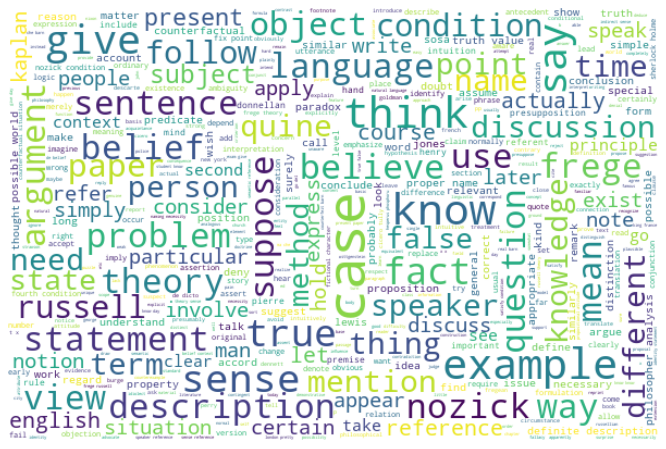

In [500]:
showwordcloud(t1)

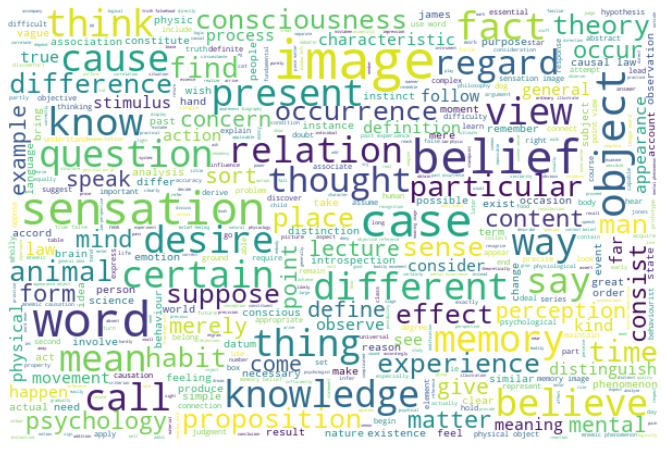

In [502]:
t2 = texts[texts.title == 'The Analysis Of Mind'].text.iloc[0]
showwordcloud(t2)

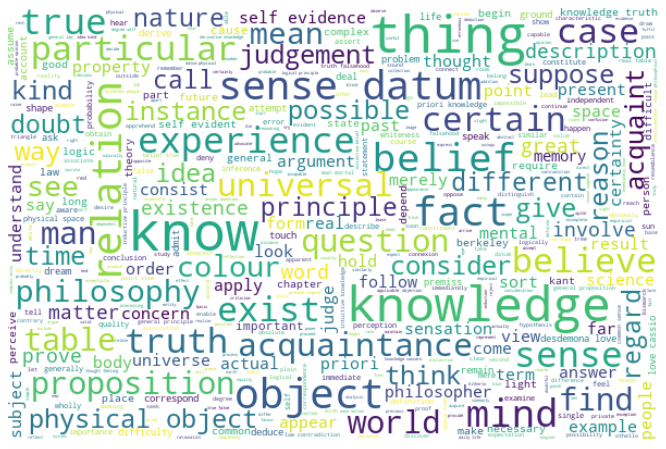

In [503]:
t3 = texts[texts.title == 'The Problems Of Philosophy'].text.iloc[0]
showwordcloud(t3)

## Essential Works Of Lenin	 Lenin & Marx communism
Lenin mentioned Marx 382 times in the work.

In [561]:
temp_df = df[df.title == 'Essential Works Of Lenin']
temp_df = temp_df[[x.find('marx') != -1 for x in temp_df.sentence_lowered]]
mentioned_sentence = list(temp_df.sentence_lowered)
mentioned_sentence[:5]

['the realization of the product in capitalist society (and, consequently, the realization of surplus value) cannot be explained unless we understand that: the value of the social product, like that of the individual product, is divided into three parts and not into two (constant capital variable capital surplus value, and not only into variable capital surplus value, as adam smith and the whole of subsequent political economy prior to marx taught) and that in its natural form it should be divided into two main subdivisions: means of production (consumed productively) and articles of consumption (for personal consumption).',
 'having laid down these main theoretical postulates marx fully explained the process of realizing the product in general and surplus value in particular in capitalist production, and revealed that it was utterly wrong to drag the foreign market into the question of realization.',
 "marx's theory of realization also shed light on the question of national consumptio

### sentiment analysis

In [ ]:
df1=pd.DataFrame()
df1['row_id']=['99999999999']
df1['sentiment_type']='NA999NA'
df1['sentiment_score']=0

In [562]:
df_t = df[df.title == 'Essential Works Of Lenin']
df_t = df_t.reset_index()
df_t['row_id'] = df_t.index + 1
df_t = df_t[['row_id', 'sentence_lowered']]
df_t

,row_id,sentence_lowered
0,1,which are directly related to the question of ...
1,2,the fundamental process of the formation of a ...
2,3,"this means that, one after another, various fo..."
3,4,"thus, agriculture itself becomes an industry (..."
4,5,the direct deduction from the preceding postul...
...,...,...
4464,4465,there is really no essential difference betwee...
4465,4466,"taking this circumstance into consideration, w..."
4466,4467,the experience of the commune has been not onl...
4467,4468,instead of inculcating in the workers' minds t...


In [563]:
df_subset = df_t[['sentence_lowered']]
df_subset = df_subset.reset_index()
df_subset['row_id'] = df_subset.index + 1
df_subset = df_subset[['row_id', 'sentence_lowered']]
df_subset

,row_id,sentence_lowered
0,1,which are directly related to the question of ...
1,2,the fundamental process of the formation of a ...
2,3,"this means that, one after another, various fo..."
3,4,"thus, agriculture itself becomes an industry (..."
4,5,the direct deduction from the preceding postul...
...,...,...
4464,4465,there is really no essential difference betwee...
4465,4466,"taking this circumstance into consideration, w..."
4466,4467,the experience of the commune has been not onl...
4467,4468,instead of inculcating in the workers' minds t...


In [564]:
print('Processing sentiment analysis...')
sid = SentimentIntensityAnalyzer()
t_df = df1
for index, row in df_subset.iterrows():
    scores = sid.polarity_scores(row[1])
    for key, value in scores.items():
        temp = [key,value,row[0]]
        df1['row_id']=row[0]
        df1['sentiment_type']=key
        df1['sentiment_score']=value
        t_df=t_df.append(df1)
        
t_df_cleaned = t_df[t_df.row_id != '99999999999']

t_df_cleaned = t_df_cleaned.drop_duplicates()

t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
t_df_cleaned

Processing sentiment analysis...


,row_id,sentiment_type,sentiment_score
0,1,compound,0.0000
0,2,compound,0.0000
0,3,compound,0.0000
0,4,compound,0.0000
0,5,compound,0.0000
...,...,...,...
0,4465,compound,-0.5095
0,4466,compound,0.1689
0,4467,compound,-0.4968
0,4468,compound,0.1027


In [565]:
df_output = pd.merge(df_t, t_df_cleaned, on='row_id', how='inner')
df_output

,row_id,sentence_lowered,sentiment_type,sentiment_score
0,1,which are directly related to the question of ...,compound,0.0000
1,2,the fundamental process of the formation of a ...,compound,0.0000
2,3,"this means that, one after another, various fo...",compound,0.0000
3,4,"thus, agriculture itself becomes an industry (...",compound,0.0000
4,5,the direct deduction from the preceding postul...,compound,0.0000
...,...,...,...,...
4464,4465,there is really no essential difference betwee...,compound,-0.5095
4465,4466,"taking this circumstance into consideration, w...",compound,0.1689
4466,4467,the experience of the commune has been not onl...,compound,-0.4968
4467,4468,instead of inculcating in the workers' minds t...,compound,0.1027


In [566]:
df_output.sentiment_score.describe()

count    4469.000000
mean        0.048487
std         0.424585
min        -0.978300
25%        -0.226300
50%         0.000000
75%         0.361200
max         0.969700
Name: sentiment_score, dtype: float64

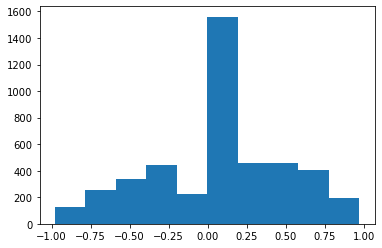

In [567]:
plt.hist(df_output.sentiment_score);

The min value is -0.978300, which indicates the polarity or intensity of the most negative response is strongly negative (range of sentiment polarity score is -1 to +1).
The max value is +0.969700, which indicates the polarity or intensity of the most positive response is highly positive.
The mean value is +0.048487 which indicates the average polarity or intensity of sentiment across all responses is almost neutral.

In [568]:
df_marx = df_output[[x.find('marx') != -1 for x in df_output.sentence_lowered]]
df_marx

,row_id,sentence_lowered,sentiment_type,sentiment_score
12,13,the realization of the product in capitalist s...,compound,0.8807
13,14,having laid down these main theoretical postul...,compound,-0.4865
14,15,marx's theory of realization also shed light o...,compound,0.0000
16,17,that is precisely why the marxian theory nowhe...,compound,0.0000
53,54,as the starting point of this genesis marx tak...,compound,-0.2960
...,...,...,...,...
4424,4425,his question about officials clearly shows tha...,compound,0.4019
4433,4434,it was precisely the example of the commune th...,compound,0.0000
4434,4435,"in essence, the whole of kautsky's argument ag...",compound,0.6461
4441,4442,marx's critico analytical genius perceived in ...,compound,-0.3703


In [570]:
df_marx.sentiment_score.describe()

count    339.000000
mean      -0.001307
std        0.424868
min       -0.938200
25%       -0.298350
50%        0.000000
75%        0.308000
max        0.959600
Name: sentiment_score, dtype: float64

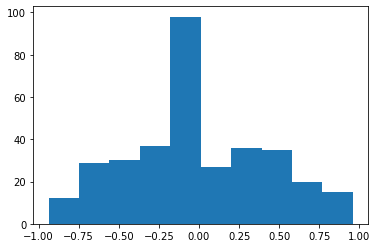

In [571]:
plt.hist(df_marx.sentiment_score);

The general sentiment of the sentence mentioning Marx keeps the same, though the most often sentiment changes from positive to negative.

In [572]:
df_marx[df_marx.sentiment_score < -0.8].sentence_lowered.iloc[0]

"marx wrote: 'the working class in the course of its development will substitute for the old civil society an association which will exclude classes and their antagonism, and there will be no more political power properly so called, since political power is precisely the official expression of antagonism in civil society.'"

In [573]:
df_marx[df_marx.sentiment_score < 0.9].sentence_lowered.iloc[0]

'the realization of the product in capitalist society (and, consequently, the realization of surplus value) cannot be explained unless we understand that: the value of the social product, like that of the individual product, is divided into three parts and not into two (constant capital variable capital surplus value, and not only into variable capital surplus value, as adam smith and the whole of subsequent political economy prior to marx taught) and that in its natural form it should be divided into two main subdivisions: means of production (consumed productively) and articles of consumption (for personal consumption).'

The result makes sense as most citations are just proof of arguements, not a personal attitude towards Marx.

### similarity

In [574]:
t1 = texts[texts.title == 'Essential Works Of Lenin'].text.iloc[0]

In [575]:
df[df.author == 'Marx'].title.drop_duplicates()

289938                    Capital
302934    The Communist Manifesto
Name: title, dtype: object

In [580]:
arr2[45].mean()

0.3272999596904973

In [577]:
arr2[45, 43]

0.4089465010967199

In [578]:
arr2[45, 44]

0.5230232048473045

'The Communist Manifesto' is the article with the largest similarity.   
Also 'Capital' has the similarity higher than average.

## correlation btw similarity and citation

In [590]:
titles

array(['Plato - Complete Works', 'Aristotle - Complete Works',
       'Second Treatise On Government',
       'Essay Concerning Human Understanding',
       'A Treatise Of Human Nature',
       'Dialogues Concerning Natural Religion', 'Three Dialogues',
       'A Treatise Concerning The Principles Of Human Knowledge',
       'Ethics', 'On The Improvement Of Understanding', 'Theodicy',
       'Discourse On Method', 'Meditations On First Philosophy',
       'The Search After Truth', 'The Analysis Of Mind',
       'The Problems Of Philosophy', 'Philosophical Studies',
       'Philosophical Investigations', 'Tractatus Logico-Philosophicus',
       'Lewis - Papers', 'Quintessence',
       'The Logic Of Scientific Discovery', 'Naming And Necessity',
       'Philosophical Troubles', 'On Certainty',
       'The Birth Of The Clinic', 'History Of Madness',
       'The Order Of Things', 'Writing And Difference',
       'Difference And Repetition', 'Anti-Oedipus',
       'The Phenomenology Of Perc

In [586]:
np.fill_diagonal(arr2, np.nan)

In [713]:
similarity2 = pd.DataFrame(arr2, columns=titles)
similarity2['title'] = titles

In [714]:
similarity2['author'] = [title2author[x] for x in similarity2.title]
similarity2 = similarity2.set_index('author')
similarity2 = similarity2.drop(columns=['title'])

In [710]:
similarity = pd.DataFrame(columns=titles)

for philosopher in philosophers:
    temp_df = similarity2[similarity2.index == philosopher]
    if len(temp_df) != 1:
        temp_df.loc['mean'] = temp_df.mean()
        temp_df = td.tail(1)
        temp_df.index = [philosopher]
    similarity = similarity.append(temp_df)

/Users/lizhenni/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [712]:
for column in similarity.columns:
     similarity.loc[title2author[column]][column] = np.nan
similarity

,Plato - Complete Works,Aristotle - Complete Works,Second Treatise On Government,Essay Concerning Human Understanding,A Treatise Of Human Nature,Dialogues Concerning Natural Religion,Three Dialogues,A Treatise Concerning The Principles Of Human Knowledge,Ethics,On The Improvement Of Understanding,...,Enchiridion,Meditations,The Antichrist,Beyond Good And Evil,Ecce Homo,Twilight Of The Idols,Thus Spake Zarathustra,Vindication Of The Rights Of Woman,The Second Sex,"Women, Race, And Class"
Plato,NaN,0.742036,0.553567,0.536947,0.504460,0.552436,0.501190,0.508259,0.510620,0.516559,...,0.595235,0.414771,0.569533,0.646533,0.619137,0.669326,0.381272,0.533567,0.531952,0.249626
Aristotle,0.742036,NaN,0.504813,0.570988,0.601960,0.618014,0.553917,0.594576,0.569026,0.584235,...,0.560729,0.415864,0.525343,0.626470,0.595013,0.646227,0.328278,0.542201,0.516848,0.231757
Locke,0.257744,0.290567,NaN,NaN,0.246406,0.249271,0.175027,0.213246,0.187841,0.206198,...,0.203220,0.134621,0.260643,0.301154,0.280993,0.310868,0.130319,0.249686,0.261090,0.187547
Hume,0.257744,0.290567,0.283755,0.209287,NaN,NaN,0.175027,0.213246,0.187841,0.206198,...,0.203220,0.134621,0.260643,0.301154,0.280993,0.310868,0.130319,0.249686,0.261090,0.187547
Berkeley,0.257744,0.290567,0.283755,0.209287,0.246406,0.249271,NaN,NaN,0.187841,0.206198,...,0.203220,0.134621,0.260643,0.301154,0.280993,0.310868,0.130319,0.249686,0.261090,0.187547
Spinoza,0.257744,0.290567,0.283755,0.209287,0.246406,0.249271,0.175027,0.213246,NaN,NaN,...,0.203220,0.134621,0.260643,0.301154,0.280993,0.310868,0.130319,0.249686,0.261090,0.187547
Leibniz,0.651212,0.637403,0.515623,0.514476,0.561313,0.628360,0.477703,0.518991,0.573363,0.510473,...,0.510893,0.383026,0.623933,0.621424,0.568991,0.680697,0.334174,0.519811,0.464535,0.191757
Descartes,0.257744,0.290567,0.283755,0.209287,0.246406,0.249271,0.175027,0.213246,0.187841,0.206198,...,0.203220,0.134621,0.260643,0.301154,0.280993,0.310868,0.130319,0.249686,0.261090,0.187547
Malebranche,0.657199,0.710487,0.471806,0.668016,0.671425,0.615404,0.622199,0.689689,0.662336,0.648599,...,0.500465,0.386776,0.549435,0.608187,0.546213,0.631884,0.323600,0.569507,0.484772,0.184851
Russell,0.257744,0.290567,0.283755,0.209287,0.246406,0.249271,0.175027,0.213246,0.187841,0.206198,...,0.203220,0.134621,0.260643,0.301154,0.280993,0.310868,0.130319,0.249686,0.261090,0.187547


In [734]:
similar = similarity.values.reshape(-1,).tolist()
similar[:10]

[nan,
 0.742036351736399,
 0.5535666216226129,
 0.5369473717490559,
 0.5044597786527214,
 0.5524358791671152,
 0.5011895951853407,
 0.5082593330241657,
 0.5106196865435604,
 0.5165591889028892]

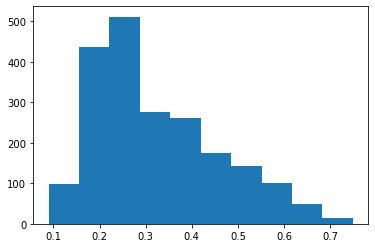

In [781]:
plt.hist(similar);

In [731]:
references

,Plato - Complete Works,Aristotle - Complete Works,Second Treatise On Government,Essay Concerning Human Understanding,A Treatise Of Human Nature,Dialogues Concerning Natural Religion,Three Dialogues,A Treatise Concerning The Principles Of Human Knowledge,Ethics,On The Improvement Of Understanding,...,Enchiridion,Meditations,The Antichrist,Beyond Good And Evil,Ecce Homo,Twilight Of The Idols,Thus Spake Zarathustra,Vindication Of The Rights Of Woman,The Second Sex,"Women, Race, And Class"
philosophers,,,,,,,,,,,,,,,,,,,,,
Plato,9999,76,0,7,2,1,0,0,0,0,...,0,7,2,23,4,26,0,2,29,0
Aristotle,0,9999,0,2,0,0,0,2,0,0,...,0,0,1,0,2,4,0,0,10,0
Locke,8,8,9999,9999,3,0,0,1,0,0,...,0,0,0,4,0,0,3,2,19,3
Hume,0,0,0,0,9999,9999,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
Berkeley,0,0,0,0,1,0,9999,9999,0,0,...,0,0,0,1,0,0,0,0,0,0
Spinoza,0,0,0,0,6,0,1,0,9999,9999,...,0,0,1,5,0,4,0,0,1,0
Leibniz,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,2,0,0,1,0
Descartes,0,0,0,4,0,0,0,0,2,0,...,0,0,2,3,1,2,0,0,1,0
Malebranche,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [735]:
refer = references.values.reshape(-1,).tolist()
refer[:10]

[9999, 76, 0, 7, 2, 1, 0, 0, 0, 0]

In [739]:
refer = [x for x in refer if x != 9999]
len(refer)

2065

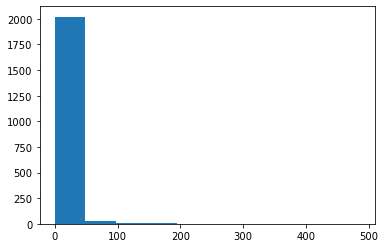

In [756]:
plt.hist(refer);

right skewed distribution

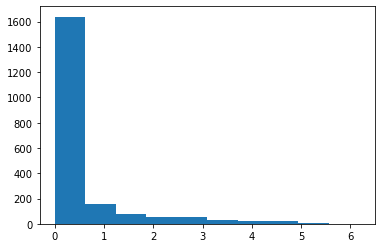

In [764]:
refer_log = [log1p(x) for x in refer]
plt.hist(refer_log);

In [795]:
similar = [x for x in similar if not np.isnan(x)]
len(similar)

2065

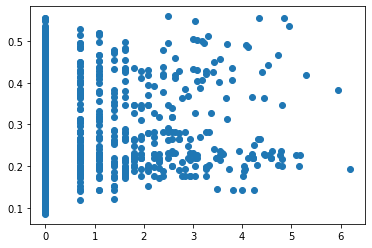

In [784]:
pyplot.scatter(refer_log, similar)
pyplot.show()

In [789]:
# calculate the Pearson's correlation between two variables
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr

# seed random number generator
seed(1)
# prepare data

# calculate Pearson's correlation
corr, _ = pearsonr(refer_log, similar)
print('Pearsons correlation: %.3f' % corr)


Pearsons correlation: 0.067


Unfortunatly, statistically, the result does not approve the correlation between reference and similarity.

### are the titles in the text?

In [307]:
refered_titles = titles
references2 = pd.DataFrame()
references2['refered_titles'] = refered_titles

for title in titles:
    reference = []
    temp_df = df[df.title == title]
    for refered_title in refered_titles:
        temp = 0
        for sentence in temp_df.sentence_lowered:
            if refered_title != title and sentence.find(refered_title.lower()) > -1:
                temp += 1
        reference.append(temp)
    references2[title] = reference

In [308]:
references2

,refered_titles,Plato - Complete Works,Aristotle - Complete Works,Second Treatise On Government,Essay Concerning Human Understanding,A Treatise Of Human Nature,Dialogues Concerning Natural Religion,Three Dialogues,A Treatise Concerning The Principles Of Human Knowledge,Ethics,...,Enchiridion,Meditations,The Antichrist,Beyond Good And Evil,Ecce Homo,Twilight Of The Idols,Thus Spake Zarathustra,Vindication Of The Rights Of Woman,The Second Sex,"Women, Race, And Class"
0,Plato - Complete Works,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aristotle - Complete Works,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Second Treatise On Government,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Essay Concerning Human Understanding,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A Treatise Of Human Nature,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Dialogues Concerning Natural Religion,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Three Dialogues,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,A Treatise Concerning The Principles Of Human ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Ethics,1,10,0,3,4,1,0,0,0,...,0,0,0,2,0,0,0,0,2,2
9,On The Improvement Of Understanding,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [310]:
references2.sum(axis=1)

/var/folders/pn/8ps1h0fs0cx57rhg5p2mv1tr0000gn/T/ipykernel_94280/3608786100.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  references2.sum(axis=1)


0        0
1        0
2        0
3        4
4        5
5        0
6        1
7        2
8      225
9        0
10       4
11       3
12       2
13       3
14       0
15       2
16       2
17       7
18       0
19       0
20       7
21       0
22      51
23       0
24       6
25       0
26      15
27      16
28       0
29       1
30       0
31       1
32       0
33       1
34      10
35       1
36      12
37       4
38      94
39       1
40       4
41      29
42       0
43    2715
44      18
45       0
46       7
47       0
48       0
49       0
50     100
51       5
52      13
53       2
54       6
55       5
56       1
57       0
58       0
dtype: int64

Other than the frequently used words like 'capital', 'ethics' and 'Meditations', there's nearly no direct citation in the text.

## get the similarity of the docs

In [279]:
texts = df[['title', 'author', 'school']].drop_duplicates()

In [280]:
temp_text = []
for title in titles:
    df_temp = df[df.title==title]
    text = " ".join(txt for txt in df_temp.sentence_lowered)
    
    temp_text.append(text)
    
texts['text'] = temp_text

In [281]:
texts = texts.reset_index()

In [211]:
vect = TfidfVectorizer(min_df=1, stop_words="english")
tfidf = vect.fit_transform(list(texts.text))
pairwise_similarity = tfidf * tfidf.T

Transform the documents into TF-IDF vectors, remove the punctuations, and then compute the cosine similarity between them.

reasons: cosine similarity is generally preferred over Euclidean distance when working with text data as cosine similarity is not affected by the magnitude/length of the feature vectors.

In [285]:
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

tfidf = vectorizer.fit_transform(list(texts.text))
pairwise_similarity2 = tfidf * tfidf.T

/Users/lizhenni/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop

In [396]:
arr2 = pairwise_similarity2.toarray()
np.fill_diagonal(arr2, 1)

In [325]:
similar_book = []
its_author = []
its_school = []
similarity = []

for i in range(0, 59):
    result_idx = np.nanargmax(arr2[i])
    similar_book.append(texts.title[result_idx])
    similarity.append(arr2[i, result_idx])
    its_author.append(texts.author[result_idx])
    its_school.append(texts.school[result_idx])

In [326]:
texts['similar article'] = similar_book
texts['similar article author'] = its_author
texts['similar article school'] = its_school
texts['similarity'] = similarity

In [329]:
texts = texts[['title', 'author', 'school', 'text', 'similar article',
               'similar article author', 'similar article school', 'similarity']]

In [330]:
texts

,title,author,school,text,similar article,similar article author,similar article school,similarity
0,Plato - Complete Works,Plato,plato,"what's new, socrates, to make you leave your ...",Aristotle - Complete Works,Aristotle,aristotle,0.742036
1,Aristotle - Complete Works,Aristotle,aristotle,when things have only a name in common and th...,Plato - Complete Works,Plato,plato,0.742036
2,Second Treatise On Government,Locke,empiricism,"reader, thou hast here the beginning and end o...",Plato - Complete Works,Plato,plato,0.553567
3,Essay Concerning Human Understanding,Locke,empiricism,i have put into thy hands what has been the di...,A Treatise Concerning The Principles Of Human ...,Berkeley,empiricism,0.843079
4,A Treatise Of Human Nature,Hume,empiricism,my design in the present work is sufficiently ...,Dialogues Concerning Natural Religion,Hume,empiricism,0.731468
5,Dialogues Concerning Natural Religion,Hume,empiricism,"it has been remarked, my that though the ancie...",A Treatise Of Human Nature,Hume,empiricism,0.731468
6,Three Dialogues,Berkeley,empiricism,"good morrow, hylas: i did not expect to find ...",A Treatise Concerning The Principles Of Human ...,Berkeley,empiricism,0.839936
7,A Treatise Concerning The Principles Of Human ...,Berkeley,empiricism,philosophy being nothing else but it may with ...,Essay Concerning Human Understanding,Locke,empiricism,0.843079
8,Ethics,Spinoza,rationalism,"by that which is self caused, i mean that of w...",On The Improvement Of Understanding,Spinoza,rationalism,0.683804
9,On The Improvement Of Understanding,Spinoza,rationalism,after experience had taught me that all the u...,Meditations On First Philosophy,Descartes,rationalism,0.751992


In [391]:
arr2

array([[       nan, 0.74203635, 0.55356662, ..., 0.53356713, 0.53195234,
        0.24962611],
       [0.74203635,        nan, 0.50481348, ..., 0.54220117, 0.51684796,
        0.23175737],
       [0.55356662, 0.50481348,        nan, ..., 0.5051284 , 0.43093664,
        0.20655762],
       ...,
       [0.53356713, 0.54220117, 0.5051284 , ...,        nan, 0.67930003,
        0.45822368],
       [0.53195234, 0.51684796, 0.43093664, ..., 0.67930003,        nan,
        0.49782975],
       [0.24962611, 0.23175737, 0.20655762, ..., 0.45822368, 0.49782975,
               nan]])

In [400]:
def create_heatmap(similarity, cmap = "YlGnBu"):
    df = pd.DataFrame(similarity)
    df.columns = titles
    df.index = titles
    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(df, cmap=cmap)

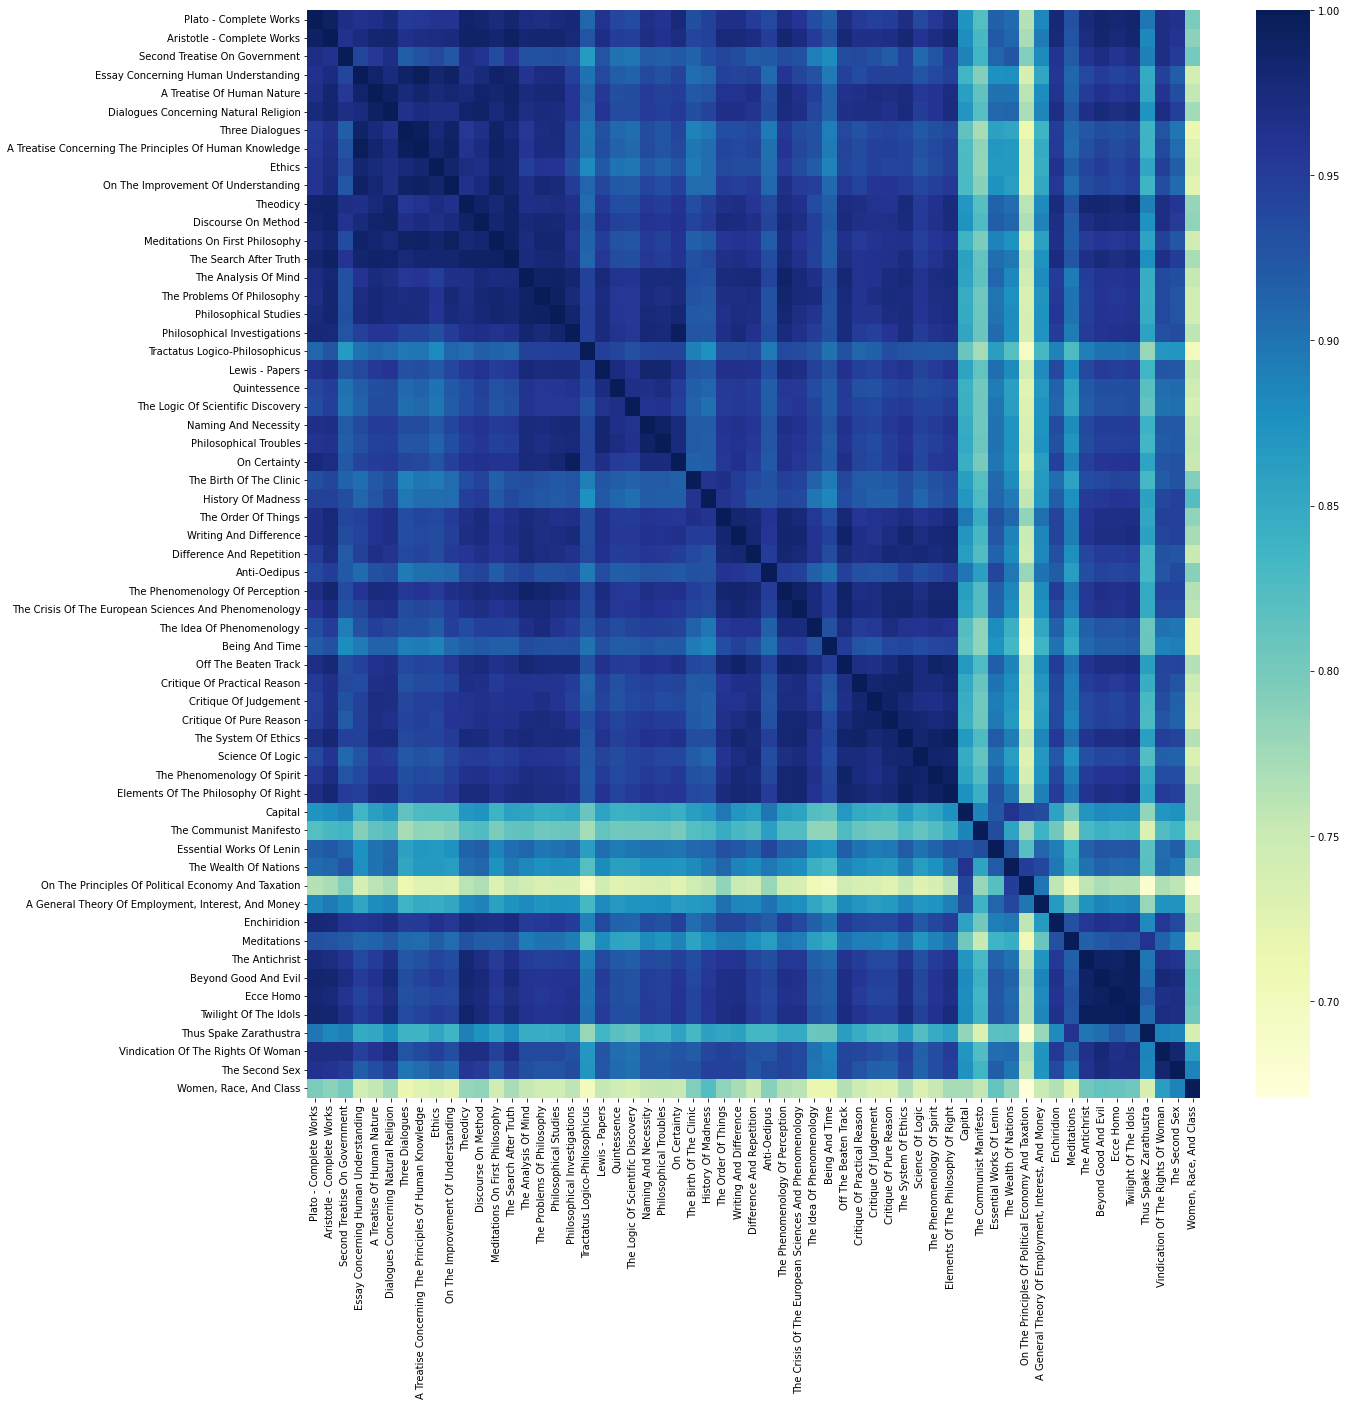

In [401]:
from sklearn.metrics.pairwise import cosine_similarity

create_heatmap(cosine_similarity(arr2))

we noticed there're bright lines on 'Women, Race And Class', 'On the principle of Political Economy And Taxation', which are not similar with other articles.

### try spacy similarity

In [353]:
STOP_WORDS = spacy.lang.en.stop_words.STOP_WORDS

In [354]:
print(nlp.Defaults.stop_words)

{'through', 'somewhere', 'anywhere', 'yourselves', 'on', 'when', 'more', 'wherever', 'has', 'part', 'they', 'side', 'few', 'seems', 'nowhere', 'he', 'beside', 'twelve', 'been', 'herself', 'whereafter', 'since', 'any', 'at', 'not', 'sometimes', 'every', 'from', 'an', 'here', 'latterly', 'somehow', 'again', 'whatever', "'ve", 'least', 'nevertheless', 'them', 'this', 'see', 'whereupon', 'if', 're', 'none', 'we', 'empty', 'thru', 'with', 'my', 'mostly', 'than', 'rather', '’ll', 'would', 'two', 'fifteen', 'used', 'same', 'well', 'various', '’ve', 'do', 'done', 'almost', 'themselves', '‘m', 'both', 'before', 'are', 'even', 'indeed', 'seem', 'bottom', 'others', 'noone', 'whence', 'anyone', 'of', 'onto', 'enough', 'afterwards', 'down', 'formerly', 'him', 'those', 'move', 'between', 'hereby', 'along', 'should', 'whereas', 'put', 'also', 'back', 'during', 'becomes', 'me', 'a', 'ever', 'being', 'n’t', 'say', 'due', 'up', 'had', 'anyway', 'our', 'moreover', 'whereby', 'you', 'beyond', 'eleven', 'f

In [355]:
nlp.Defaults.stop_words |= {"else", "always"}

In [356]:
# remove stop words
# nlp.Defaults.stop_words.remove("remove")

In [499]:
nlp.max_length = 7523000

In [378]:
def process_text(text):
    doc = nlp(text)
    result = []
    for token in doc:
        if token.text in nlp.Defaults.stop_words:
            continue
        if token.is_punct:
            continue
        if token.lemma_ == '-PRON-':
            continue
        result.append(token.lemma_)
    return " ".join(result)

In [390]:
doc1 = nlp(texts.text[3])
doc2 = nlp(texts.text[20])
doc1.similarity(doc2)

0.9883679724527558

the similarity is too high to reference to.